In [ ]:
from active_critic.utils.gym_utils import (
    make_vec_env, 
    make_dummy_vec_env, 
    sample_expert_transitions_rollouts, 
    make_pomdp_rollouts, 
    make_dummy_vec_env_pomdp,
    get_avr_succ_rew_det
)
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from imitation.algorithms import bc
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from stable_baselines3.common.evaluation import evaluate_policy
import warnings
from typing import Any, Dict, Optional, Type, Union

import numpy as np
import torch as th
from gym import spaces
from torch.nn import functional as F

from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import ActorCriticCnnPolicy, ActorCriticPolicy, BasePolicy, MultiInputActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import explained_variance,  get_schedule_fn

from torch.utils.data import DataLoader
from imitation.algorithms.adversarial import gail 
from imitation.util.networks import RunningNorm
from imitation.rewards.reward_nets import BasicRewardNet
from stable_baselines3.ppo import MlpPolicy
from active_critic.utils.tboard_graphs import TBoardGraphs
from active_critic.model_src.transformer import PositionalEncoding

import copy

from active_critic.TQC.tqc import TQC
from active_critic.TQC.tqc_policy import TQCPolicyEval

def run_experiment(device):
    pass
device='cuda'
lookup_freq = 1
env, vec_expert = make_dummy_vec_env(name='pickplace', seq_len=200)
val_env, _ = make_dummy_vec_env(name='pickplace', seq_len=200)

transitions, rollouts = sample_expert_transitions_rollouts(vec_expert.predict, env, 10)
env.envs[0].reset_count = 0
pomdp_rollouts = make_pomdp_rollouts(rollouts, lookup_frq=lookup_freq, count_dim=10)
pomdp_transitions = rollout.flatten_trajectories(pomdp_rollouts)

pomdp_env, pomdp_vec_expert = make_dummy_vec_env_pomdp(name='pickplace', seq_len=200, lookup_freq=lookup_freq)
policy_kwargs = {'net_arch' : [32, 32, 32]}
tqc_learner = TQC(policy='MlpPolicy', env=pomdp_env, device=device, policy_kwargs=policy_kwargs)

    

In [ ]:
tqc_learner = TQC(policy='MlpPolicy', env=pomdp_env, device=device, policy_kwargs=policy_kwargs)

bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=pomdp_transitions,
    device=device,
    policy=tqc_learner.policy)
th.save(bc_trainer.policy.state_dict(), 'test')
policy = copy.deepcopy(bc_trainer.policy)

In [20]:
def evaluate_learner(env_tag, logname, save_path, seq_len, n_demonstrations, bc_epochs, n_samples, device, learner:TQC=None):
    lookup_freq = 1000
    env, vec_expert = make_dummy_vec_env(name=env_tag, seq_len=seq_len)
    val_env, _ = make_dummy_vec_env(name=env_tag, seq_len=seq_len)
    transitions, rollouts = sample_expert_transitions_rollouts(vec_expert.predict, val_env, n_demonstrations)

    pomdp_rollouts = make_pomdp_rollouts(rollouts, lookup_frq=lookup_freq, count_dim=10)
    pomdp_transitions = rollout.flatten_trajectories(pomdp_rollouts)

    if learner is None:
        bc_learner = bc.BC(
            observation_space=env.observation_space,
            action_space=env.action_space,
            demonstrations=pomdp_transitions,
            device=device)
    else:
        bc_learner = bc.BC(
            observation_space=env.observation_space,
            action_space=env.action_space,
            demonstrations=pomdp_transitions,
            device=device,
            policy=learner.policy)

    pomdp_env_val, pomdp_vec_expert = make_dummy_vec_env_pomdp(name=env_tag, seq_len=seq_len, lookup_freq=lookup_freq)

    tboard = TBoardGraphs(logname=logname + ' BC' , data_path='/data/bing/hendrik/gboard/')
    best_succes_rate = -1
    best_model = None
    runs_per_epoch = 20
    for i in range(bc_epochs):
        bc_learner.train(n_epochs=runs_per_epoch)
        success, rews = get_avr_succ_rew_det(env=pomdp_env_val, learner=bc_learner.policy, epsiodes=200)
        success_rate = success.mean()
        tboard.addValidationScalar('Reward', value=th.tensor(rews.mean()), stepid=i)
        tboard.addValidationScalar('Success Rate', value=th.tensor(success_rate), stepid=i)
        if success_rate > best_succes_rate:
            best_succes_rate = success_rate
            th.save(bc_learner.policy.state_dict(), save_path + logname + ' BC best')
            print(save_path + logname + ' BC best')
    
    if learner is not None:

        tboard = TBoardGraphs(logname=logname + str(' Reinforcement') , data_path='/data/bing/hendrik/gboard/')
        learner.policy.load_state_dict(th.load(save_path + logname + ' BC best'))
        success, rews = get_avr_succ_rew_det(env=pomdp_env_val, learner=learner.policy, epsiodes=200)
        tboard.addValidationScalar('Reloaded Success Rate', value=th.tensor(success.mean()), stepid=0)
        tboard.addValidationScalar('Reloaded Reward', value=th.tensor(rews.mean()), stepid=0)

        tboard.addValidationScalar('Reward', value=th.tensor(rews.mean()), stepid=pomdp_env.envs[0].reset_count)
        tboard.addValidationScalar('Success Rate', value=th.tensor(success_rate), stepid=pomdp_env.envs[0].reset_count)

        while learner.env.envs[0].reset_count <= n_samples:
            print('before learn')
            learner.learn(2000)
            print('after learn')
            print(learner.env.envs[0].reset_count)
            success, rews = get_avr_succ_rew_det(env=pomdp_env_val, learner=learner.policy, epsiodes=200)
            success_rate = success.mean()
            tboard.addValidationScalar('Reward', value=th.tensor(rews.mean()), stepid=pomdp_env.envs[0].reset_count)
            tboard.addValidationScalar('Success Rate', value=th.tensor(success_rate), stepid=pomdp_env.envs[0].reset_count)

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.138   |
|    entropy        | 138      |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 451      |
|    loss           | 138      |
|    neglogp        | 138      |
|    prob_true_act  | 0.00275  |
|    samples_so_far | 32       |
--------------------------------


482batch [00:02, 190.04batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.017    |
|    entropy        | -17      |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 498      |
|    loss           | -17      |
|    neglogp        | -17      |
|    prob_true_act  | 1.59e+11 |
|    samples_so_far | 16032    |
--------------------------------


985batch [00:05, 194.97batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0183   |
|    entropy        | -18.3    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 533      |
|    loss           | -18.3    |
|    neglogp        | -18.3    |
|    prob_true_act  | 2.48e+10 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 192.41batch/s]


/data/bing/hendrik/Evaluate Baseline/TQC 10 BC best


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0143   |
|    entropy        | -14.3    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 548      |
|    loss           | -14.3    |
|    neglogp        | -14.3    |
|    prob_true_act  | 3.91e+10 |
|    samples_so_far | 32       |
--------------------------------


500batch [00:02, 178.78batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0179   |
|    entropy        | -17.9    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 571      |
|    loss           | -17.9    |
|    neglogp        | -17.9    |
|    prob_true_act  | 9.87e+11 |
|    samples_so_far | 16032    |
--------------------------------


996batch [00:05, 155.09batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0202   |
|    entropy        | -20.2    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 590      |
|    loss           | -20.2    |
|    neglogp        | -20.2    |
|    prob_true_act  | 6.15e+10 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 183.07batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0167   |
|    entropy        | -16.7    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 598      |
|    loss           | -16.6    |
|    neglogp        | -16.7    |
|    prob_true_act  | 1.49e+10 |
|    samples_so_far | 32       |
--------------------------------


496batch [00:02, 195.40batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0207   |
|    entropy        | -20.7    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 617      |
|    loss           | -20.7    |
|    neglogp        | -20.7    |
|    prob_true_act  | 6.52e+10 |
|    samples_so_far | 16032    |
--------------------------------


984batch [00:05, 185.66batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0192   |
|    entropy        | -19.2    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 635      |
|    loss           | -19.2    |
|    neglogp        | -19.2    |
|    prob_true_act  | 2.61e+11 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 188.46batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0165   |
|    entropy        | -16.5    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 644      |
|    loss           | -16.4    |
|    neglogp        | -16.5    |
|    prob_true_act  | 3.5e+12  |
|    samples_so_far | 32       |
--------------------------------


497batch [00:02, 190.05batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0191   |
|    entropy        | -19.1    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 665      |
|    loss           | -19.1    |
|    neglogp        | -19.1    |
|    prob_true_act  | 7.83e+09 |
|    samples_so_far | 16032    |
--------------------------------


984batch [00:04, 200.88batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0187   |
|    entropy        | -18.7    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 684      |
|    loss           | -18.7    |
|    neglogp        | -18.7    |
|    prob_true_act  | 1.58e+11 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 197.24batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0202   |
|    entropy        | -20.2    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 694      |
|    loss           | -20.2    |
|    neglogp        | -20.2    |
|    prob_true_act  | 8.64e+11 |
|    samples_so_far | 32       |
--------------------------------


480batch [00:02, 199.97batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0201   |
|    entropy        | -20.1    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 717      |
|    loss           | -20.1    |
|    neglogp        | -20.1    |
|    prob_true_act  | 8.18e+11 |
|    samples_so_far | 16032    |
--------------------------------


988batch [00:04, 207.88batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0219   |
|    entropy        | -21.9    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 735      |
|    loss           | -21.8    |
|    neglogp        | -21.9    |
|    prob_true_act  | 2.47e+11 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 201.81batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0237   |
|    entropy        | -23.7    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 744      |
|    loss           | -23.7    |
|    neglogp        | -23.7    |
|    prob_true_act  | 4.12e+11 |
|    samples_so_far | 32       |
--------------------------------


485batch [00:02, 206.19batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0216   |
|    entropy        | -21.6    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 761      |
|    loss           | -21.5    |
|    neglogp        | -21.6    |
|    prob_true_act  | 1.55e+12 |
|    samples_so_far | 16032    |
--------------------------------


980batch [00:05, 149.41batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0218   |
|    entropy        | -21.8    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 779      |
|    loss           | -21.8    |
|    neglogp        | -21.8    |
|    prob_true_act  | 5.97e+12 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 179.47batch/s]


/data/bing/hendrik/Evaluate Baseline/TQC 10 BC best


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0245   |
|    entropy        | -24.5    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 787      |
|    loss           | -24.5    |
|    neglogp        | -24.5    |
|    prob_true_act  | 2.4e+13  |
|    samples_so_far | 32       |
--------------------------------


500batch [00:02, 200.12batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0254   |
|    entropy        | -25.4    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 804      |
|    loss           | -25.4    |
|    neglogp        | -25.4    |
|    prob_true_act  | 6.5e+12  |
|    samples_so_far | 16032    |
--------------------------------


993batch [00:04, 209.23batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0181   |
|    entropy        | -18.1    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 822      |
|    loss           | -18.1    |
|    neglogp        | -18.1    |
|    prob_true_act  | 3.17e+13 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 203.54batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.023    |
|    entropy        | -23      |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 830      |
|    loss           | -23      |
|    neglogp        | -23      |
|    prob_true_act  | 1.19e+13 |
|    samples_so_far | 32       |
--------------------------------


487batch [00:02, 196.01batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0211   |
|    entropy        | -21.1    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 846      |
|    loss           | -21.1    |
|    neglogp        | -21.1    |
|    prob_true_act  | 5.08e+13 |
|    samples_so_far | 16032    |
--------------------------------


981batch [00:05, 197.19batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.024    |
|    entropy        | -24      |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 861      |
|    loss           | -24      |
|    neglogp        | -24      |
|    prob_true_act  | 2.57e+12 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 183.04batch/s]


/data/bing/hendrik/Evaluate Baseline/TQC 10 BC best


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0217   |
|    entropy        | -21.7    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 871      |
|    loss           | -21.7    |
|    neglogp        | -21.7    |
|    prob_true_act  | 7.37e+11 |
|    samples_so_far | 32       |
--------------------------------


500batch [00:02, 196.41batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0251   |
|    entropy        | -25.1    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 888      |
|    loss           | -25.1    |
|    neglogp        | -25.1    |
|    prob_true_act  | 1.3e+14  |
|    samples_so_far | 16032    |
--------------------------------


993batch [00:05, 195.70batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0239   |
|    entropy        | -23.9    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 904      |
|    loss           | -23.9    |
|    neglogp        | -23.9    |
|    prob_true_act  | 1.44e+12 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 193.38batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0231   |
|    entropy        | -23.1    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 912      |
|    loss           | -23      |
|    neglogp        | -23.1    |
|    prob_true_act  | 7.21e+11 |
|    samples_so_far | 32       |
--------------------------------


500batch [00:02, 195.71batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0238   |
|    entropy        | -23.8    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 928      |
|    loss           | -23.8    |
|    neglogp        | -23.8    |
|    prob_true_act  | 6.79e+13 |
|    samples_so_far | 16032    |
--------------------------------


983batch [00:04, 201.01batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0206   |
|    entropy        | -20.6    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 945      |
|    loss           | -20.6    |
|    neglogp        | -20.6    |
|    prob_true_act  | 7.31e+13 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 198.19batch/s]


/data/bing/hendrik/Evaluate Baseline/TQC 10 BC best


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0238   |
|    entropy        | -23.8    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 954      |
|    loss           | -23.8    |
|    neglogp        | -23.8    |
|    prob_true_act  | 2.49e+12 |
|    samples_so_far | 32       |
--------------------------------


481batch [00:02, 200.08batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.024    |
|    entropy        | -24      |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 972      |
|    loss           | -23.9    |
|    neglogp        | -24      |
|    prob_true_act  | 4.07e+13 |
|    samples_so_far | 16032    |
--------------------------------


999batch [00:05, 200.38batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0228   |
|    entropy        | -22.8    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 990      |
|    loss           | -22.7    |
|    neglogp        | -22.8    |
|    prob_true_act  | 2.21e+12 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 199.17batch/s]


/data/bing/hendrik/Evaluate Baseline/TQC 10 BC best


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0258   |
|    entropy        | -25.8    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 998      |
|    loss           | -25.8    |
|    neglogp        | -25.8    |
|    prob_true_act  | 1.57e+12 |
|    samples_so_far | 32       |
--------------------------------


480batch [00:02, 205.26batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0255   |
|    entropy        | -25.5    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.02e+03 |
|    loss           | -25.5    |
|    neglogp        | -25.5    |
|    prob_true_act  | 1.86e+13 |
|    samples_so_far | 16032    |
--------------------------------


993batch [00:05, 192.89batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0228   |
|    entropy        | -22.8    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.03e+03 |
|    loss           | -22.8    |
|    neglogp        | -22.8    |
|    prob_true_act  | 1.36e+12 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 197.92batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0259   |
|    entropy        | -25.9    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.04e+03 |
|    loss           | -25.9    |
|    neglogp        | -25.9    |
|    prob_true_act  | 5.02e+16 |
|    samples_so_far | 32       |
--------------------------------


500batch [00:02, 187.98batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0256   |
|    entropy        | -25.6    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.06e+03 |
|    loss           | -25.6    |
|    neglogp        | -25.6    |
|    prob_true_act  | 8.04e+12 |
|    samples_so_far | 16032    |
--------------------------------


997batch [00:05, 200.57batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0226   |
|    entropy        | -22.6    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.08e+03 |
|    loss           | -22.5    |
|    neglogp        | -22.6    |
|    prob_true_act  | 1.04e+12 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 194.44batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0246   |
|    entropy        | -24.6    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.08e+03 |
|    loss           | -24.6    |
|    neglogp        | -24.6    |
|    prob_true_act  | 2.77e+14 |
|    samples_so_far | 32       |
--------------------------------


498batch [00:02, 172.96batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0253   |
|    entropy        | -25.3    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.1e+03  |
|    loss           | -25.3    |
|    neglogp        | -25.3    |
|    prob_true_act  | 3.13e+12 |
|    samples_so_far | 16032    |
--------------------------------


984batch [00:05, 195.28batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.024    |
|    entropy        | -24      |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.12e+03 |
|    loss           | -24      |
|    neglogp        | -24      |
|    prob_true_act  | 8.95e+12 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 190.68batch/s]


/data/bing/hendrik/Evaluate Baseline/TQC 10 BC best


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0227   |
|    entropy        | -22.7    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.13e+03 |
|    loss           | -22.7    |
|    neglogp        | -22.7    |
|    prob_true_act  | 6.62e+13 |
|    samples_so_far | 32       |
--------------------------------


491batch [00:02, 195.04batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0225   |
|    entropy        | -22.5    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.14e+03 |
|    loss           | -22.5    |
|    neglogp        | -22.5    |
|    prob_true_act  | 6.89e+13 |
|    samples_so_far | 16032    |
--------------------------------


988batch [00:05, 191.51batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0243   |
|    entropy        | -24.3    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.16e+03 |
|    loss           | -24.3    |
|    neglogp        | -24.3    |
|    prob_true_act  | 5.38e+13 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 195.30batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0259   |
|    entropy        | -25.9    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.17e+03 |
|    loss           | -25.9    |
|    neglogp        | -25.9    |
|    prob_true_act  | 1.78e+14 |
|    samples_so_far | 32       |
--------------------------------


482batch [00:02, 207.09batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0265   |
|    entropy        | -26.5    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.18e+03 |
|    loss           | -26.5    |
|    neglogp        | -26.5    |
|    prob_true_act  | 1.45e+14 |
|    samples_so_far | 16032    |
--------------------------------


997batch [00:05, 191.93batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0237   |
|    entropy        | -23.7    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.2e+03  |
|    loss           | -23.7    |
|    neglogp        | -23.7    |
|    prob_true_act  | 2.15e+12 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 194.17batch/s]


/data/bing/hendrik/Evaluate Baseline/TQC 10 BC best


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.023    |
|    entropy        | -23      |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.21e+03 |
|    loss           | -22.9    |
|    neglogp        | -23      |
|    prob_true_act  | 2.28e+12 |
|    samples_so_far | 32       |
--------------------------------


491batch [00:02, 211.40batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0253   |
|    entropy        | -25.3    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.23e+03 |
|    loss           | -25.3    |
|    neglogp        | -25.3    |
|    prob_true_act  | 1.32e+14 |
|    samples_so_far | 16032    |
--------------------------------


995batch [00:04, 192.74batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.027    |
|    entropy        | -27      |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.25e+03 |
|    loss           | -27      |
|    neglogp        | -27      |
|    prob_true_act  | 4.13e+12 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 198.00batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0238   |
|    entropy        | -23.8    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.25e+03 |
|    loss           | -23.8    |
|    neglogp        | -23.8    |
|    prob_true_act  | 8.87e+13 |
|    samples_so_far | 32       |
--------------------------------


491batch [00:05, 198.11batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0221   |
|    entropy        | -22.1    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.27e+03 |
|    loss           | -22      |
|    neglogp        | -22.1    |
|    prob_true_act  | 7.86e+11 |
|    samples_so_far | 16032    |
--------------------------------


995batch [00:08, 208.00batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0268   |
|    entropy        | -26.8    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.29e+03 |
|    loss           | -26.8    |
|    neglogp        | -26.8    |
|    prob_true_act  | 4.2e+12  |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:09, 130.49batch/s]


/data/bing/hendrik/Evaluate Baseline/TQC 10 BC best


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0254   |
|    entropy        | -25.4    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.29e+03 |
|    loss           | -25.4    |
|    neglogp        | -25.4    |
|    prob_true_act  | 3.58e+12 |
|    samples_so_far | 32       |
--------------------------------


495batch [00:02, 206.86batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0244   |
|    entropy        | -24.4    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.31e+03 |
|    loss           | -24.4    |
|    neglogp        | -24.4    |
|    prob_true_act  | 3.52e+14 |
|    samples_so_far | 16032    |
--------------------------------


999batch [00:05, 201.92batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0271   |
|    entropy        | -27.1    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.32e+03 |
|    loss           | -27.1    |
|    neglogp        | -27.1    |
|    prob_true_act  | 7.72e+13 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 198.76batch/s]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | 0.0247   |
|    entropy        | -24.7    |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 1.33e+03 |
|    loss           | -24.7    |
|    neglogp        | -24.7    |
|    prob_true_act  | 4.91e+13 |
|    samples_so_far | 32       |
--------------------------------


488batch [00:02, 181.00batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 500      |
|    ent_loss       | 0.0234   |
|    entropy        | -23.4    |
|    epoch          | 8        |
|    l2_loss        | 0        |
|    l2_norm        | 1.35e+03 |
|    loss           | -23.4    |
|    neglogp        | -23.4    |
|    prob_true_act  | 2.38e+12 |
|    samples_so_far | 16032    |
--------------------------------


986batch [00:05, 188.86batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 1000     |
|    ent_loss       | 0.0255   |
|    entropy        | -25.5    |
|    epoch          | 16       |
|    l2_loss        | 0        |
|    l2_norm        | 1.36e+03 |
|    loss           | -25.5    |
|    neglogp        | -25.5    |
|    prob_true_act  | 6.53e+12 |
|    samples_so_far | 32032    |
--------------------------------


1240batch [00:06, 178.51batch/s]


/data/bing/hendrik/Evaluate Baseline/TQC 10 BC best
before learn
after learn
10
before learn
after learn
20
before learn
after learn
30


KeyboardInterrupt: 

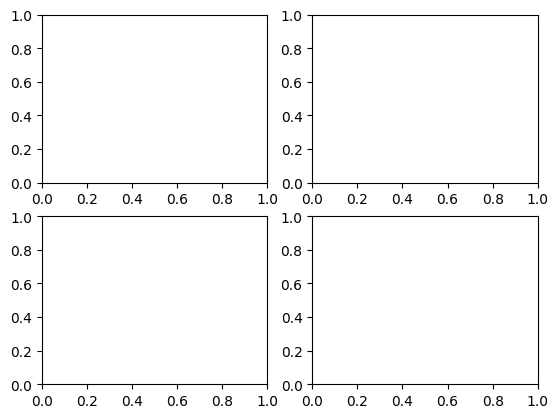

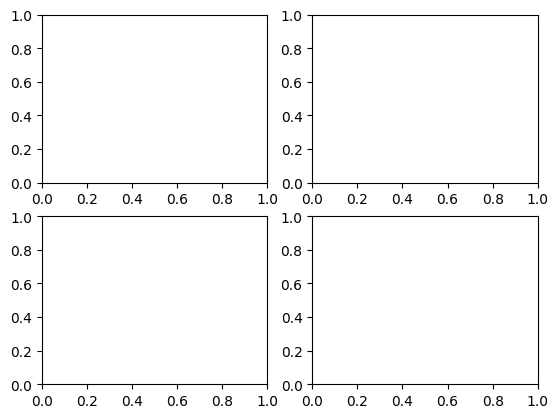

In [21]:
device = 'cuda'
env_tag = 'pickplace'
seq_len = 200
pomdp_env, pomdp_vec_expert = make_dummy_vec_env_pomdp(name=env_tag, seq_len=seq_len, lookup_freq=lookup_freq)
tqc_learner = TQC(policy='MlpPolicy', env=pomdp_env, device=device)
evaluate_learner(env_tag, 'TQC 10', save_path='/data/bing/hendrik/Evaluate Baseline/', seq_len=seq_len, n_demonstrations=10, bc_epochs=400, n_samples=400, device='cuda', learner=tqc_learner)